2. Implement a SIFT key point detector from scratch in python. For an image, (any image), compare your implementation with openCV implementation (with same parameters). If your code is not 95%-105% as efficient (compare run times) and not >75% accurate (precision/recall) as opencv, you will get a zero on this question. UNLESS you can find the exact reasons -- meaning pinpoint exact reasons -- for it not being as good as opencv. For example you can prove that opencv convolution is faster than your/numpy convolution (this is not true; its just and example of pinpoint reason). (25 pts) Use Shrek images to test above out.  
Stick to the key point detector algorithm for now, not the feature description part. 

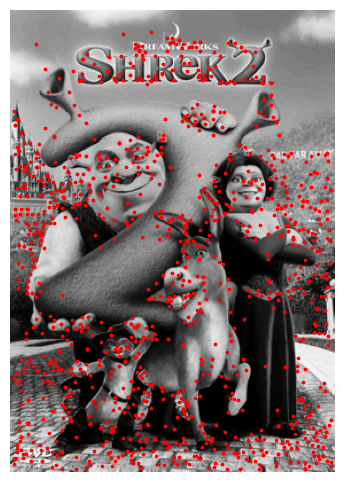

Time taken: 0.014353036880493164


In [2]:
import cv2
import matplotlib.pyplot as plt
import time

shreklarge = cv2.imread('reference.png')
gray_shreklarge = cv2.cvtColor(shreklarge,cv2.COLOR_BGR2GRAY)
shreksmall = cv2.imread('test.png')
gray_shreksmall = cv2.cvtColor(shreksmall,cv2.COLOR_BGR2GRAY)

start = time.time()
sift = cv2.SIFT_create()
keypoints1 = sift.detect(gray_shreklarge, None)
opencvtime1 = time.time() - start

# Plot the keypoints as red dots using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(gray_shreklarge, cmap='gray')

# Extract x and y coordinates of the keypoints and plot them as red points
for kp in keypoints1:
    plt.scatter(kp.pt[0], kp.pt[1], c='red', s=3)  # kp.pt gives (x, y)

plt.axis('off')
# save the plot
plt.savefig('shreklarge_keypoints.png', bbox_inches='tight')
plt.show()

print("Time taken:",opencvtime1)

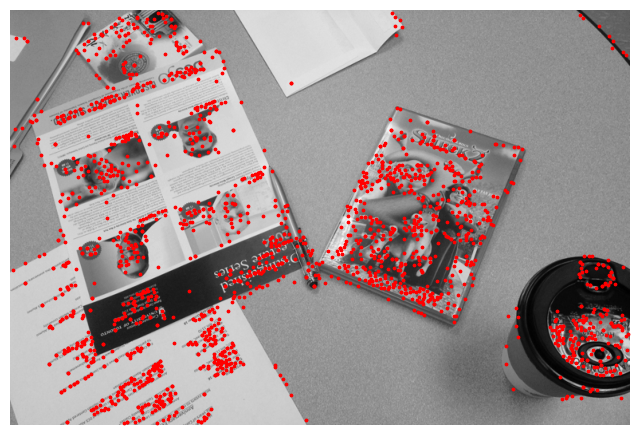

Time taken: 0.061493873596191406


In [4]:
shreksmall = cv2.imread('test.png')
gray_shreksmall = cv2.cvtColor(shreksmall,cv2.COLOR_BGR2GRAY)

start = time.time()
sift = cv2.SIFT_create()
keypoints2 = sift.detect(gray_shreksmall, None)
opencvtime2 = time.time() - start

# Plot the keypoints as red dots using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(gray_shreksmall, cmap='gray')

# Extract x and y coordinates of the keypoints and plot them as red points
for kp in keypoints2:
    plt.scatter(kp.pt[0], kp.pt[1], c='red', s=3)  # kp.pt gives (x, y)

plt.axis('off')
plt.savefig('shreksmall_keypoints.png', bbox_inches='tight')
plt.show()

print("Time taken:",opencvtime2)

SIFT Detector Implementation in Python

Algorithm:

1. Generate base image for the gaussian kernel image pyramid.

2. Generate the gaussian kernels for each layer of the image pyramid.

3. Produce blurred and downsampled images for the gaussian kernel image pyramid.

4. Get the difference of gaussians from the layers of the image pyramid in (3) to get approximations of the laplacian convolution of the image at different sigma values.

5. Use the obtained DoG image pyramid to compute the keypoints by finding local maxima among the different layers for a neighbourhood of pixels.

6. Scale back the keypoints to the input image size.

Final Implementation: cell [final](#final)(vectorized)

Implementation using simple for loops:

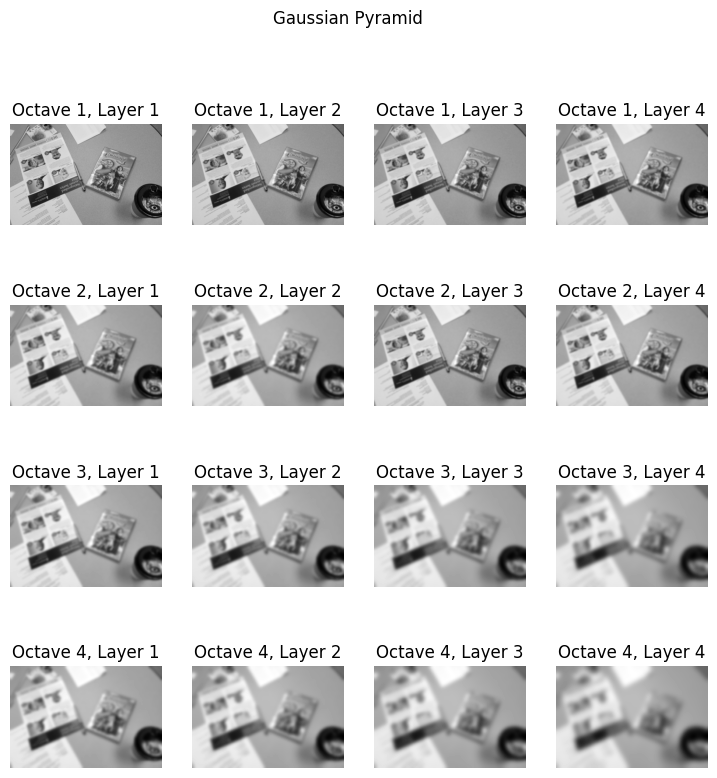

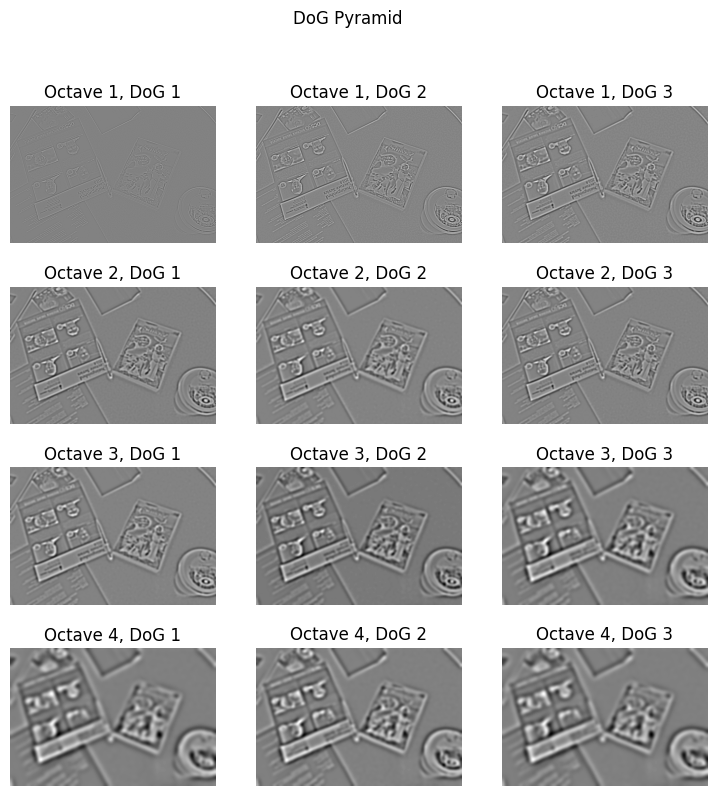

In [3]:
import numpy as np
from scipy.ndimage import gaussian_filter
import time
import matplotlib.pyplot as plt

# I have refered to the opencv github repository while working on my implementation: https://github.com/opencv/opencv/blob/4.x/modules/features2d/src/sift.dispatch.cpp#L309

class SIFT_Keypoint_Detector:
    def __init__(self, nfeatures=0, nLayersinOctave=3, contrastThreshold=0.01, 
                 edgeThreshold=10, sigma=1.6):
        self.nfeatures = nfeatures
        self.nLayersinOctave = nLayersinOctave
        self.contrastThreshold = contrastThreshold
        self.edgeThreshold = edgeThreshold
        self.sigma = sigma
        self.SIFT_FIXPT_SCALE = 1

    def create_initial_image(self, img, double_image_size=False):
        if len(img.shape) == 3:
            gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
        else:
            gray = img
        gray_float = gray.astype(np.float32) * self.SIFT_FIXPT_SCALE
        sig_diff = np.sqrt(max(self.sigma**2 - (1.6**2 * 4), 0.01))
        
        if double_image_size:
            gray_float = np.repeat(np.repeat(gray_float, 2, axis=0), 2, axis=1)
        
        return gaussian_filter(gray_float, sig_diff)

    def build_Gaussian_Pyramid(self, base, nOctaves):
        sigma = [self.sigma]
        k = 2**(1. / self.nLayersinOctave)
        for i in range(1, self.nLayersinOctave + 3):
            sigma_prev = k**(i - 1) * self.sigma
            sigma_total = sigma_prev * k
            sigma.append(np.sqrt(sigma_total**2 - sigma_prev**2))

        pyramid = []
        for o in range(nOctaves):
            octave = []
            # + 3 as we need nLayersinOctave + 2 DoG so that every image can be compared with one sigma above and below and +1, so need nLayersinOctave + 3 images in each octave to get these nLayersinOctave + 2 DoG images for each octave
            for i in range(self.nLayersinOctave + 3):
                if o == 0 and i == 0:
                    octave.append(base)
                elif i == 0:
                    # downsample the last image from the previous octave
                    prev_octave_last = pyramid[(o - 1) * (self.nLayersinOctave + 3) + self.nLayersinOctave]
                    # downsample the image to half width and height by taking every second pixel
                    base = prev_octave_last[::2, ::2]  
                    octave.append(base)
                else:
                    # apply gaussian blur
                    src = octave[-1]
                    dst = gaussian_filter(src, sigma[i])
                    octave.append(dst)
            pyramid.extend(octave)
        return pyramid

    def build_DoG_Pyramid(self, Gaussian_Pyramid, nOctaves):
        dogpyr = []
        for o in range(nOctaves):
            octave = []
            for i in range(1, self.nLayersinOctave + 3):
                idx = o * (self.nLayersinOctave + 3) + i
                dog = Gaussian_Pyramid[idx] - Gaussian_Pyramid[idx - 1]
                octave.append(dog)
            dogpyr.extend(octave)
        return dogpyr

    def find_scale_space_extrema(self, DoG_pyramid):
        threshold = int(0.5 * self.contrastThreshold / self.nLayersinOctave * 255 * self.SIFT_FIXPT_SCALE)
        keypoints = []

        for o in range(len(DoG_pyramid) // (self.nLayersinOctave + 2)):
            for i in range(1, self.nLayersinOctave + 1):
                idx = o * (self.nLayersinOctave + 2) + i
                img = DoG_pyramid[idx]
                prev = DoG_pyramid[idx - 1]
                next = DoG_pyramid[idx + 1]

                window_view = np.lib.stride_tricks.sliding_window_view(img, (3, 3))
                center = window_view[:, :, 1, 1]
                neighbors = np.dstack([
                    window_view[:, :, 0, 0], window_view[:, :, 0, 1], window_view[:, :, 0, 2],
                    window_view[:, :, 1, 0], window_view[:, :, 1, 2],
                    window_view[:, :, 2, 0], window_view[:, :, 2, 1], window_view[:, :, 2, 2]
                ])

                prev_window = np.lib.stride_tricks.sliding_window_view(prev, (3, 3))
                next_window = np.lib.stride_tricks.sliding_window_view(next, (3, 3))

                is_max = (np.abs(center) > threshold) & (center > 0) & \
                         (center > neighbors.max(axis=2)) & \
                         (center > prev_window.max(axis=(2, 3))) & \
                         (center > next_window.max(axis=(2, 3)))

                is_min = (np.abs(center) > threshold) & (center < 0) & \
                         (center < neighbors.min(axis=2)) & \
                         (center < prev_window.min(axis=(2, 3))) & \
                         (center < next_window.min(axis=(2, 3)))

                extrema = np.logical_or(is_max, is_min)
                y, x = np.where(extrema)
                keypoints.extend([(o, i, r+1, c+1) for r, c in zip(y, x)])

        return keypoints

    def detect_keypoints(self, img):
        base = self.create_initial_image(img)
        nOctaves = int(round(np.log(min(base.shape)) / np.log(2) - 2))
        gpyr = self.build_Gaussian_Pyramid(base, nOctaves)
        dogpyr = self.build_DoG_Pyramid(gpyr, nOctaves)
        keypoints = self.find_scale_space_extrema(dogpyr)
        
        if self.nfeatures > 0 and len(keypoints) > self.nfeatures:
            keypoints = keypoints[:self.nfeatures]
        
        return keypoints
    
    # we have the keypoints as tuples (octave,layer_in_octave,y,x) now, but they are different scales of the image(downsampling after each octave). So we need to scale them back w.r.t. the original image using their octave value
    def draw_keypoints(self,gray_img, keypoints, markersize=2):
        plt.imshow(gray_img, cmap='gray')
        height, width = gray_img.shape[:2]
        for (o, i, y, x) in keypoints:
            # scale the keypoint coordinates back to the input image scale
            scale = 2**o
            y_scaled = y * scale
            x_scaled = x * scale
            plt.plot(x_scaled, y_scaled, 'ro', markersize=markersize)
        plt.title('Manual Keypoint Detection')
        plt.show()

sift_detector = SIFT_Keypoint_Detector()
gaussian_pyramid = sift_detector.build_Gaussian_Pyramid(sift_detector.create_initial_image(gray_shreksmall), 4)
dog_pyramid = sift_detector.build_DoG_Pyramid(gaussian_pyramid, 4)
# plot gaussian pyramid
plt.figure(figsize=(9, 9))
for o in range(4):
    for l in range(4):
        plt.subplot(4, 4, o * 4 + l + 1)
        plt.imshow(gaussian_pyramid[o * 4 + l], cmap='gray')
        plt.axis('off')
        plt.title(f'Octave {o+1}, Layer {l+1}')
plt.suptitle('Gaussian Pyramid')
plt.show()
# plot the DoG pyramid
plt.figure(figsize=(9, 9))
for o in range(4):
    for l in range(3):
        plt.subplot(4, 3, o * 3 + l + 1)
        plt.imshow(dog_pyramid[o * 3 + l], cmap='gray')
        plt.axis('off')
        plt.title(f'Octave {o+1}, DoG {l+1}')
plt.suptitle('DoG Pyramid')
plt.show()

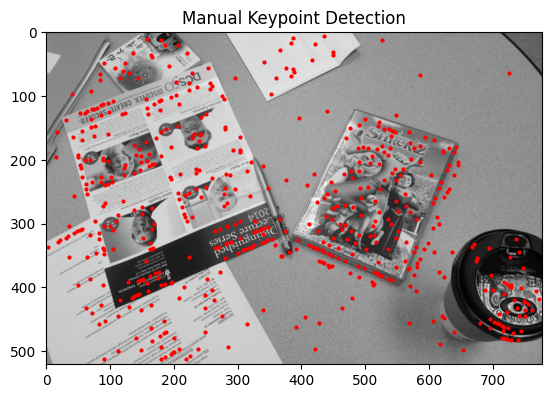

Time taken: 0.34829282760620117
Number of keypoints: 548


In [4]:
start = time.time()
sift_detector = SIFT_Keypoint_Detector()
keypoints = sift_detector.detect_keypoints(gray_shreksmall)
scratch_impl_time = time.time() - start
sift_detector.draw_keypoints(gray_shreksmall, keypoints)
print("Time taken:",scratch_impl_time)
print("Number of keypoints:",len(keypoints))

The points do not closely follow the output of opencv, and not enough keypoints have been identified. Let's see if we can improve this.

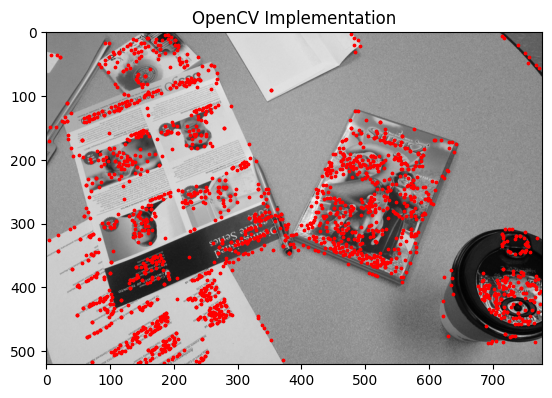

Time taken: 0.07145190238952637
Number of keypoints: 1961


In [5]:
import cv2
import matplotlib.pyplot as plt
import time

shreklarge = cv2.imread('reference.png')
gray_shreklarge = cv2.cvtColor(shreklarge,cv2.COLOR_BGR2GRAY)
shreksmall = cv2.imread('test.png')
gray_shreksmall = cv2.cvtColor(shreksmall,cv2.COLOR_BGR2GRAY)

start = time.time()
sift = cv2.SIFT_create()
keypoints1 = sift.detect(gray_shreksmall, None)
opencvtime1 = time.time() - start

plt.imshow(gray_shreksmall, cmap='gray')
for kp in keypoints1:
    plt.scatter(kp.pt[0], kp.pt[1], c='red', s=3)
plt.title('OpenCV Implementation')
plt.show()

print("Time taken:",opencvtime1)
print("Number of keypoints:",len(keypoints1))

### Optimising my implementation with vectorization and improving the scale space maxima detection

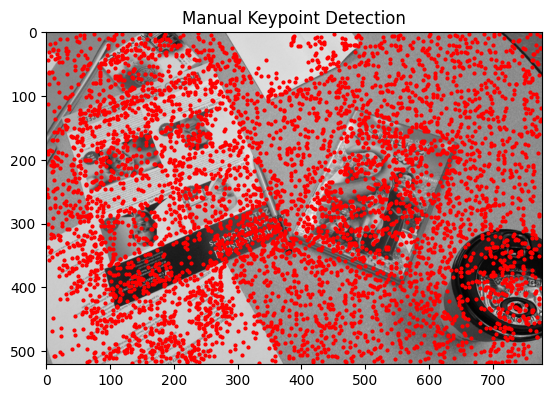

Time taken: 0.14145588874816895
Number of keypoints: 5065

Tweaking parameters to reduce the number of keypoints:


/var/folders/vg/c0z21yg92qd0jhn0p09c9x200000gp/T/ipykernel_37060/173390473.py:125: RuntimeWarning: divide by zero encountered in divide
  edge_response = (tr ** 2) / det


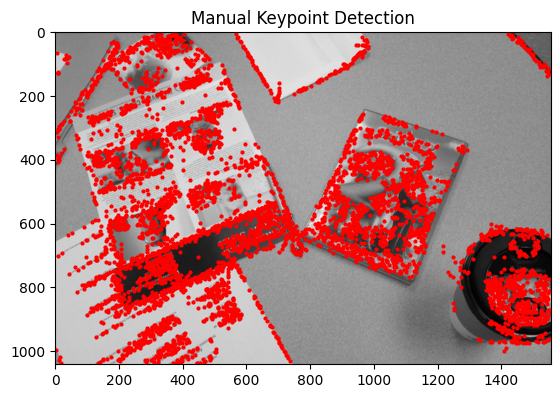

Time taken: 0.7361118793487549
Number of keypoints: 5104


In [11]:
import numpy as np
from scipy.ndimage import gaussian_filter
import time
import matplotlib.pyplot as plt

# I have refered to the opencv github repository while working on my implementation: https://github.com/opencv/opencv/blob/4.x/modules/features2d/src/sift.dispatch.cpp#L309

class SIFT_Keypoint_Detector:
    def __init__(self, nfeatures=0, nLayersinOctave=5, contrastThreshold=0.01, 
                 edgeThreshold=10, sigma=1.6):
        # not required for our implementation, but kept for reference
        self.nfeatures = nfeatures
        # number of progressive blurring of an image done in each octave (the number of octaves is calculated from the input image - dimensions halved after each octave)
        self.nLayersinOctave = nLayersinOctave
        # threshold for the contrast check in the scale space maxima detection
        self.contrastThreshold = contrastThreshold
        # threshold for the edge response check in the scale space maxima detection
        self.edgeThreshold = edgeThreshold
        # initial sigma for the first image in the image pyramid
        self.sigma = sigma
        # scaling factor for the floating point arithmetic, used as power of 2 if want to convert the floating point arithmetic to integer arithmetic
        self.SIFT_FIXPT_SCALE = 1

    def create_initial_image(self, img, double_image_size=False):
        if len(img.shape) == 3:
            gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
        else:
            gray = img
        # Im using SIFT_FIXPT_SCALE = 1, so I'm keeping arithmetic in floating point and not scaling the floating point intensities to integers
        gray_float = gray.astype(np.float32) * self.SIFT_FIXPT_SCALE
        # we want the resulting image to have a blur by factor self.sigma. Assuming it is already blurred by factor of 1.6, we calculate the additional blur sigma using (required_blur^2 - (2*current_blur)^2)
        sig_diff = np.sqrt(max(self.sigma**2 - (1.6**2 * 4), 0.01))
        
        if double_image_size:
            # I double the image size here by repeating each pixel twice in both dimensions (inner loop is for columns and outer loop is for rows)
            gray_float = np.repeat(np.repeat(gray_float, 2, axis=0), 2, axis=1)
        # apply the additional blur to the image and return the initial image
        return gaussian_filter(gray_float, sig_diff)

    # build the Gaussian pyramid
    def build_Gaussian_Pyramid(self, base, nOctaves):
        # pre-compute the sigma values requried for progressive blurring in each octave
        # the k value is here is defined in the opencv implementation and is used as the scaling factor for the progressive blurring
        k = 2**(1. / self.nLayersinOctave)
        # store sigma values for each layer in the octave (nLayersinOctave + 3 as we need nLayersinOctave + 2 DoG so that every image can be compared with one sigma above and below and +1, so need nLayersinOctave + 3 images in each octave to get these nLayersinOctave + 2 DoG images for each octave)
        sigma = np.array([k**i * self.sigma for i in range(self.nLayersinOctave + 3)])
        # calculate the effective sigma for gaussian blurring in each layer of an octave
        sigma_diff = np.sqrt(np.diff(sigma**2))

        # build the gaussian pyramid
        pyramid = []
        # over each octave
        for o in range(nOctaves):
            # create an octave array to store the layers of the octave
            # initialised with the base image for the first octave
            # otherwise initialised with the downsampled image from the last image previous octave ([::2, ::2] does the downsampling). [-3] is used instead of [-1] from the previous octave to retain detail to an extent so that a lot of detail from the original image is not lost when building the DoG pyramid
            octave = [base] if o == 0 else [pyramid[-1][-3][::2, ::2]]
            # apply progressive for each layer in an octave
            for i in range(1, self.nLayersinOctave + 3):
                # append the blurred layer to the octave array
                octave.append(gaussian_filter(octave[-1], sigma_diff[i-1]))
            # append octave to the Gaussian pyramid
            pyramid.append(octave)
            # base = octave[-3][::2, ::2]
        return pyramid

    # build the Difference of Gaussian pyramid
    def build_DoG_Pyramid(self, Gaussian_Pyramid, nOctaves):
        # using list comprehension here as appending is faster with it than normal for loops.
        # access each octave from the Gaussian pyramid and for each octave build the DoG pyramid by taking the difference of consecutive layers in the octave
        return [[octave[i+1] - octave[i] for i in range(len(octave) - 1)]
                for octave in Gaussian_Pyramid]

    # find the scale space extrema(maxima and minima) in the DoG pyramid using 3x3x3 pixel cube neighbourhoods
    def find_scale_space_extrema(self, DoG_pyramid):
        # calculate the threshold for declaring as an extrema (based on the opencv implementation - line 374)
        threshold = float(0.5 * self.contrastThreshold / self.nLayersinOctave * 255 * self.SIFT_FIXPT_SCALE)
        # build the list of keypoints by iterating over each octave and each layer in the octave with a 3x3x3 pixel cube neighbourhood
        keypoints = []
        # iterate over each octave in the DoG pyramid
        for o, octave in enumerate(DoG_pyramid):
            # iterate over each layer in the octave
            for i in range(1, len(octave) - 1):
                # for each layer(starting from the second) access the current, previous and next layers in the octave
                prev, curr, next = octave[i-1:i+2]
                
                # using sliding_window_view from numpy here for efficiency (reference: https://stackoverflow.com/a/65447214)
                window = np.lib.stride_tricks.sliding_window_view(curr, (3, 3)) # looks something like this: [[[[1,2,3],[4,5,6],[7,8,9]],[[10,11,12],[13,14,15],[16,17,18]],[[19,20,21],[22,23,24],[25,26,27]]]]
                # get the center blob of each window (3x3x3 pixel cube neighbourhood)
                center = window[:, :, 1, 1]
                # stack the neighbours of the center blob in the 3x3x3 pixel cube neighbourhood
                neighbors = np.dstack([window[:, :, i, j] for i in range(3) for j in range(3) if (i != 1 or j != 1)])
                
                # check for the local extrema in the 3x3x3 neighborhood
                # using & for element wise logical AND
                # compare with the pixels in the previos and next layers in the octave
                is_max = (np.abs(center) > threshold) & (center > 0) & \
                        (center > neighbors.max(axis=2)) & \
                        (center > prev[1:-1, 1:-1]) & (center > next[1:-1, 1:-1])
                # compare with the pixels in the previos and next layers in the octave
                is_min = (np.abs(center) > threshold) & (center < 0) & \
                        (center < neighbors.min(axis=2)) & \
                        (center < prev[1:-1, 1:-1]) & (center < next[1:-1, 1:-1])
                
                # taking both local maxima and local minima as extremas
                extrema = is_max | is_min
                
                # filter out any edge like features - cannot be used as keypoints as they are similar when slided in the direction of the edge
                # calculate the Hessian matrix for the 3x3x3 pixel cube neighbourhood
                # calculate the first order derivatives in y and x directions
                # reference: https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd
                dy = curr[1:-1, 2:] - curr[1:-1, :-2]
                dx = curr[2:, 1:-1] - curr[:-2, 1:-1]
                # calculate the second order derivatives in the x and y directions - using central difference method: f''(x) ≈ [f(x+h) + f(x-h) - 2f(x)] / h^2 [h = 1] 
                dxx = curr[1:-1, 2:] + curr[1:-1, :-2] - 2 * curr[1:-1, 1:-1]
                dyy = curr[2:, 1:-1] + curr[:-2, 1:-1] - 2 * curr[1:-1, 1:-1]
                # calculate the cross derivative
                dxy = ((curr[2:, 2:] + curr[:-2, :-2]) - (curr[2:, :-2] + curr[:-2, 2:])) / 4 # division by 4 as effectively we are effectively taking the difference twice
                # Hessian = [[dxx, dxy], [dxy, dyy]]
                # trace of the hessian matrix
                tr = dxx + dyy
                # determinant of the hessian matrix
                det = dxx * dyy - dxy ** 2
                # calculate the edge response function
                edge_response = (tr ** 2) / det
                
                # filter out the edge like features by checking the edge threshold with the edge response function
                # edge_threshold_ratio = (self.edgeThreshold + 1) ** 2 / self.edgeThreshold based on Lowe's paper section 4.1: https://link.springer.com/content/pdf/10.1023/b:visi.0000029664.99615.94.pdf
                extrema = extrema & (edge_response < (self.edgeThreshold + 1) ** 2 / self.edgeThreshold)
                # get the coordinates of the extrema
                x, y = np.where(extrema)
                # append the (octave, layer_in_octave, y, x) tuple to the keypoints list
                keypoints.extend([(o, i, r+1, c+1) for r, c in zip(y, x)])

        return keypoints

    def detect_keypoints(self, img, double_image_size=False):
        # create the initial image by applying the initial blur
        base = self.create_initial_image(img, double_image_size)
        # compute the number of possible octaves based on the image size
        nOctaves = int(round(np.log2(min(base.shape)) - 2)) # -2 is heuristic - stop at a reasonable resolution

        gpyr = self.build_Gaussian_Pyramid(base, nOctaves)
        dogpyr = self.build_DoG_Pyramid(gpyr, nOctaves)
        keypoints = self.find_scale_space_extrema(dogpyr)
        
        if self.nfeatures > 0 and len(keypoints) > self.nfeatures:
            keypoints = keypoints[:self.nfeatures]
        return keypoints
    
    def draw_keypoints(self, gray_img, keypoints, markersize=2,doubled_image_size=False):
        if doubled_image_size:
            gray_img = np.repeat(np.repeat(gray_img, 2, axis=0), 2, axis=1)
        plt.imshow(gray_img, cmap='gray')
        height, width = gray_img.shape[:2]
        keypoints_array = np.array(keypoints)
        
        # vectorized scaling of keypoint coordinates
        scales = 2 ** keypoints_array[:, 0]
        x_scaled = keypoints_array[:, 2] * scales
        y_scaled = keypoints_array[:, 3] * scales
        
        plt.plot(x_scaled, y_scaled, 'ro', markersize=markersize)
        plt.title('Manual Keypoint Detection')
        plt.show()

start = time.time()
sift_detector = SIFT_Keypoint_Detector(nfeatures=0, nLayersinOctave=3, contrastThreshold=0.01, edgeThreshold=10, sigma=1.6)
keypoints = sift_detector.detect_keypoints(gray_shreksmall)
scratch_impl_time = time.time() - start
sift_detector.draw_keypoints(gray_shreksmall, keypoints)
print("Time taken:",scratch_impl_time)
print("Number of keypoints:",len(keypoints))

print("\nTweaking parameters to reduce the number of keypoints:")
start = time.time()
sift_detector = SIFT_Keypoint_Detector(nfeatures=0, nLayersinOctave=3, contrastThreshold=0.13, edgeThreshold=10, sigma=1.6)
keypoints = sift_detector.detect_keypoints(gray_shreksmall, double_image_size=True)
scratch_impl_time = time.time() - start
sift_detector.draw_keypoints(gray_shreksmall, keypoints, doubled_image_size=True)
print("Time taken:",scratch_impl_time)
print("Number of keypoints:",len(keypoints))

In [7]:
print(shreksmall.astype(np.float32))

[[[ 50.  96. 218.]
  [ 52.  95. 220.]
  [ 56.  96. 222.]
  ...
  [ 77.  96. 100.]
  [ 74.  98.  97.]
  [ 70.  97.  99.]]

 [[ 57.  96. 222.]
  [ 58.  97. 224.]
  [ 57.  95. 222.]
  ...
  [ 82. 103. 104.]
  [ 86. 101. 103.]
  [ 84.  95. 103.]]

 [[ 60.  96. 225.]
  [ 60.  95. 224.]
  [ 61.  97. 225.]
  ...
  [ 91.  98. 100.]
  [ 94.  98. 105.]
  [ 88.  90. 101.]]

 ...

 [[141. 135. 145.]
  [135. 129. 136.]
  [141. 136. 140.]
  ...
  [127. 134. 141.]
  [126. 133. 140.]
  [121. 129. 136.]]

 [[142. 139. 148.]
  [141. 136. 145.]
  [145. 139. 144.]
  ...
  [123. 132. 139.]
  [134. 142. 149.]
  [126. 134. 141.]]

 [[135. 136. 142.]
  [142. 139. 148.]
  [137. 134. 139.]
  ...
  [125. 135. 143.]
  [126. 135. 143.]
  [126. 134. 141.]]]


I have used numpy vectorization and list comprehensions in the above implementation wherever possible. I have also added the use of edge response in the scale space maxima detection

In [8]:
start = time.time()
[i for i in range(1000)]
print("List comprehension:",time.time() - start)

start = time.time()
arr = []
for i in range(1000):
    arr.append(i)
print("For loop:",time.time() - start)

List comprehension: 5.412101745605469e-05
For loop: 6.29425048828125e-05


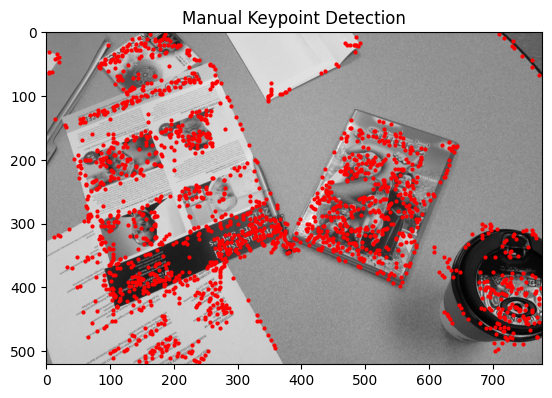

Time taken: 0.11922979354858398
Number of keypoints: 1835


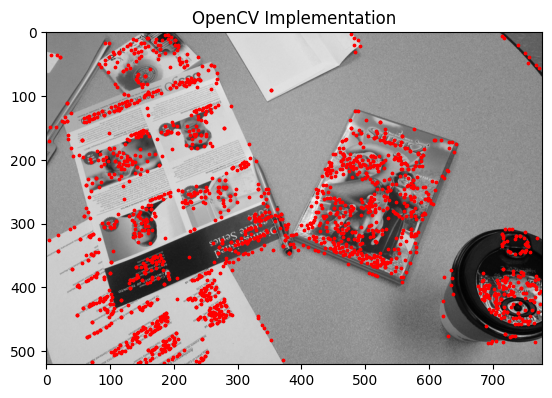

Time taken: 0.06404590606689453
Number of keypoints: 1961
Efficieny: 53.72%


In [26]:
import cv2
import matplotlib.pyplot as plt
import time

shreklarge = cv2.imread('reference.png')
gray_shreklarge = cv2.cvtColor(shreklarge,cv2.COLOR_BGR2GRAY)
shreksmall = cv2.imread('test.png')
gray_shreksmall = cv2.cvtColor(shreksmall,cv2.COLOR_BGR2GRAY)

start = time.time()
sift_detector = SIFT_Keypoint_Detector(nfeatures=0, nLayersinOctave=3, contrastThreshold=0.13, edgeThreshold=10, sigma=1.6)
keypoints = sift_detector.detect_keypoints(gray_shreksmall)
scratch_impl_time = time.time() - start
sift_detector.draw_keypoints(gray_shreksmall, keypoints)
print("Time taken:",scratch_impl_time)
print("Number of keypoints:",len(keypoints))

start = time.time()
sift = cv2.SIFT_create()
keypoints1 = sift.detect(gray_shreksmall, None)
opencvtime1 = time.time() - start

plt.imshow(gray_shreksmall, cmap='gray')
for kp in keypoints1:
    plt.scatter(kp.pt[0], kp.pt[1], c='red', s=3)
plt.title('OpenCV Implementation')
plt.show()

print("Time taken:",opencvtime1)
print("Number of keypoints:",len(keypoints1))

print(f"Efficieny: {opencvtime1/scratch_impl_time * 100:.2f}%")

In [17]:
# precision, recall and accuracy of maunual implementation with respect to open cv SIFT

keypointsopencv = [(int(kp.pt[1]), int(kp.pt[0])) for kp in keypoints1]
keypointsmanual = [(kp[2], kp[3]) for kp in keypoints]
truepositives = len(set(keypointsopencv).intersection(set(keypointsmanual)))
falsepositives = len(set(keypointsmanual).difference(set(keypointsopencv)))
falsenegatives = len(set(keypointsopencv).difference(set(keypointsmanual)))
precision = truepositives / (truepositives + falsepositives)
recall = truepositives / (truepositives + falsenegatives)
accuracy = truepositives / len(keypointsopencv)
print("Precision:",precision)
print("Recall:",recall)
print("Accuracy:",accuracy)

allowed_pixel_error = 5
print(f"\nAfter allowing an error of {allowed_pixel_error} pixels:")
# metric calculation by keeping an allowed error of 5 pixels
truepositives = 0
falsepositives = 0
falsenegatives = 0
for kp in keypointsopencv:
    if any(abs(kp[0] - kp1[0]) <= 5 and abs(kp[1] - kp1[1]) <= allowed_pixel_error for kp1 in keypointsmanual):
        truepositives += 1
    else:
        falsenegatives += 1
falsepositives = len(keypointsmanual) - truepositives
precision = truepositives / (truepositives + falsepositives)
recall = truepositives / (truepositives + falsenegatives)
accuracy = truepositives / len(keypointsopencv)
print("Precision:",precision)
print("Recall:",recall)
print("Accuracy:",accuracy)

Precision: 0.006004366812227074
Recall: 0.006984126984126984
Accuracy: 0.0056093829678735335

After allowing an error of 5 pixels:
Precision: 0.3405994550408719
Recall: 0.3187149413564508
Accuracy: 0.3187149413564508


In [11]:
print([(kp.pt[1], kp.pt[0]) for kp in keypoints1])
kp1 = keypoints1[0]
print(type(kp1.pt[0]))

[(326.2877197265625, 3.506711959838867), (170.58180236816406, 4.5541534423828125), (148.87611389160156, 5.602000713348389), (35.04631805419922, 7.628150463104248), (147.535400390625, 15.014708518981934), (34.927040100097656, 17.105667114257812), (317.8009338378906, 18.28863525390625), (342.5765380859375, 18.879968643188477), (342.5765380859375, 18.879968643188477), (39.05980682373047, 20.75743293762207), (39.05980682373047, 20.75743293762207), (139.5941619873047, 24.073444366455078), (140.0357208251953, 26.978031158447266), (131.89724731445312, 29.11858558654785), (138.3928985595703, 31.51433753967285), (138.3928985595703, 31.51433753967285), (111.43109130859375, 33.00266647338867), (111.43109130859375, 33.00266647338867), (167.07936096191406, 33.14841079711914), (161.05792236328125, 34.04719924926758), (308.8875732421875, 36.2279052734375), (126.37518310546875, 37.852317810058594), (181.8096923828125, 38.02792739868164), (370.2723388671875, 39.914363861083984), (370.2723388671875, 39.

In [12]:
[(kp[2],kp[3]) for kp in keypoints]

[(162, 2),
 (186, 3),
 (710, 3),
 (485, 7),
 (145, 8),
 (717, 9),
 (135, 10),
 (190, 10),
 (171, 11),
 (732, 13),
 (149, 16),
 (154, 17),
 (492, 17),
 (130, 18),
 (140, 18),
 (97, 19),
 (178, 19),
 (209, 19),
 (153, 20),
 (200, 20),
 (126, 21),
 (197, 22),
 (731, 22),
 (205, 23),
 (160, 24),
 (139, 25),
 (734, 25),
 (167, 26),
 (178, 26),
 (119, 27),
 (127, 27),
 (223, 27),
 (140, 28),
 (147, 28),
 (484, 30),
 (4, 31),
 (124, 31),
 (16, 34),
 (165, 34),
 (118, 35),
 (176, 36),
 (113, 37),
 (149, 37),
 (746, 37),
 (109, 39),
 (145, 40),
 (92, 42),
 (102, 44),
 (111, 44),
 (239, 44),
 (762, 44),
 (114, 45),
 (20, 46),
 (107, 46),
 (100, 47),
 (85, 48),
 (257, 50),
 (128, 51),
 (262, 52),
 (458, 52),
 (761, 54),
 (264, 57),
 (9, 62),
 (4, 63),
 (232, 64),
 (143, 65),
 (265, 67),
 (772, 67),
 (111, 69),
 (235, 69),
 (217, 71),
 (224, 73),
 (237, 73),
 (179, 74),
 (207, 74),
 (218, 77),
 (226, 77),
 (196, 78),
 (202, 78),
 (232, 78),
 (241, 78),
 (164, 79),
 (274, 79),
 (107, 81),
 (152, 84

### Despite optimising my code with vectorisation, I was not able to get the efficiency of opencv. Neither did I get the required accuracy. So let's examine why this discrepancy still exists

### Difference in runtime:
1. Opencv in python is just a wrapper for C/C++ implementations in opencv. So just calling opencv methods in python still gives extremely fast performance as compared to C/C++ code with a small penalty error (< 4% - <a link='https://stackoverflow.com/questions/13432800/does-performance-differ-between-python-or-c-coding-of-opencv'>reference</a>).

2. When we use more user defined functions in the python that are not built into numpy/scipy packages then this causes the code to be run natively in python which increases the runtime by a lot.

3. Following the reasoning in (2), even though I have optimized my code a lot using numpy vectorization, a lot of the code is not using numpy, so the runtime is not comparable to that expected from directly calling Numpy operations, and Numpy is also a wrapper for C code it should have had comparable runtime with opencv.

4. Furthermore, looping and iterations in python is a lot slower than directly usign numpy. In parts of my code this is unavoidable as I have to use loops, where even list comprehension was not possible, to access elements from an object. This has increased the runtime by a lot.

5. The runtime difference could also be there because of the number of extrema not being filtered out directly by extrema[i] == 0 in extrema = extrema & (edge_response < edge_threshold), so there is additionaly runtime for checking extrema[i] == 1 and then (edge_response[i] < edge_threshold) == 1

### Difference in Precision:

1. My implementation uses integer coordinates without quadrature approximation, while the opencv implementation uses floating-point coordinates with sub-pixel accuracy. This must be one of the primary reasons for getting the difference in the two keypoint detections.

2. I am using np.repeat(np.repeat(gray_float, 2, axis=0), 2, axis=1) and pyramid[-1][-3][::2, ::2], respectively, for upsampling and downsampling the images. For upsampling, Opencv uses warpAffine with linear interpolation which gives smoother results than simple pixel duplication (line 202 from their <a link='https://github.com/opencv/opencv/blob/4.x/modules/features2d/src/sift.dispatch.cpp#L388'>github</a>: `cv::warpAffine(gray_fpt, dbl, H, dbl.size(), INTER_LINEAR | WARP_INVERSE_MAP, BORDER_REFLECT);`), this will be resulting in different keypoints detected by my implementation and the opencv implementation. The downsampling used by opencv is `resize(src, dst, Size(src.cols/2, src.rows/2), 0, 0, INTER_NEAREST)` (line: 253) uses nearest neighbour interpolation - each pixel in the resized image corresponds to the closest pixel in the original image(no new pixel values are computed). In my implementation I have used pyramid[-1][-3][::2, ::2] which leads to a rougher approximation than in opencv, leading to different keypoints being identified.

3. Gaussian blur from my implementation: scipy.ndimage.gaussian_filter(gray_float, sig_diff), gaussian blur from the opencv implementation: GaussianBlur(dbl, result, Size(), sig_diff, sig_diff) (line:211). Not absolutely sure about this, but even though both of them are computing the kernel size using sig_diff, their methods may vary. As indicated in the following cell, the intensities do not exactly match. This may be another factor into how my implementation is detecting different keypoints.

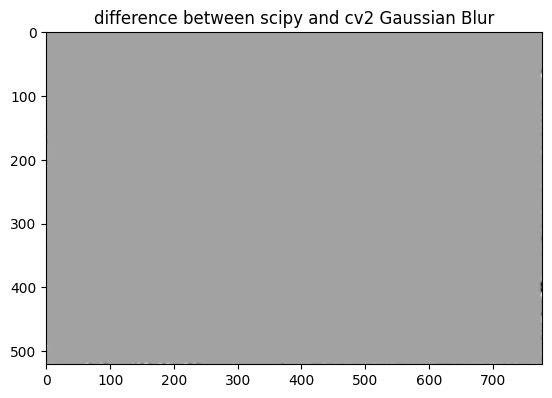

[[ 4.7171021e-01  3.4603882e-01  1.5559387e-01 ...  5.8714294e-01
   7.3989105e-01  8.5600281e-01]
 [ 2.0385742e-01  1.5037537e-01  5.8471680e-02 ...  4.4678497e-01
   6.0826874e-01  7.3768616e-01]
 [-2.5588989e-02  8.5449219e-04 -2.0599365e-03 ...  2.4682617e-01
   3.9543152e-01  5.1679993e-01]
 ...
 [-7.0523071e-01 -3.4370422e-01  1.9378662e-03 ...  8.1573486e-02
   2.1980286e-01  3.6315918e-01]
 [-3.7390137e-01 -6.6864014e-02  2.8149414e-01 ...  8.6044312e-02
   2.8330994e-01  4.5016479e-01]
 [-3.8494873e-01 -5.0262451e-02  3.9001465e-01 ... -1.5792847e-02
   1.5127563e-01  2.9460144e-01]]


In [24]:
# check if scipy.ndimage.gaussian_filter(gray_float, sig_diff) differs from cv2.GaussianBlur(gray_float, (0, 0), sig_diff)

import cv2
import numpy as np
from scipy.ndimage import gaussian_filter

img = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
gray_float = img.astype(np.float32)
sig_diff = 1.6
gaussian_blur_scipy = gaussian_filter(gray_float, sig_diff)
gaussian_blur_cv2 = cv2.GaussianBlur(gray_float, (0, 0), sig_diff)

plt.imshow(gaussian_blur_cv2 - gaussian_blur_scipy, cmap='gray')
plt.title('difference between scipy and cv2 Gaussian Blur')
plt.show()

print(gaussian_blur_cv2 - gaussian_blur_scipy)

In [13]:
# opencv gives points in float.
# manual implementation gives points in int.

# Avoid using loops in Python as much as possible, especially double/triple loops etc. They are inherently slow.
# Vectorize the algorithm/code to the maximum extent possible, because Numpy and OpenCV are optimized for vector operations.
# Exploit the cache coherence.
# Never make copies of an array unless it is necessary. Try to use views instead. Array copying is a costly operation.
